In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import tqdm

In [2]:
def empty_dir(folder):
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
        except Exception as e:
            print(e)

# Create Full/Team Pairs

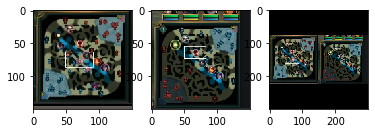

In [3]:
full_dir = "./games_collected/full/"
team_dir = "./games_collected/team/"
full = os.listdir(full_dir)
full.sort()

fig, ax = plt.subplots(1,3)

full_img = Image.open(full_dir+full[0])
ax[0].imshow(full_img);

team_img = Image.open(team_dir+full[0])
ax[1].imshow(team_img);

new_im = Image.new('RGB', (300, 300))
new_im.paste(full_img, (0,75))
new_im.paste(team_img, (150,75))
ax[2].imshow(new_im);

## Create matching pairs

In [4]:
empty_dir("./games_matched/match")
for i in tqdm.tqdm_notebook(range(len(full))):
    full_img = Image.open(full_dir+full[i])
    team_img = Image.open(team_dir+full[i])

    new_im = Image.new('RGB', (300, 300))
    new_im.paste(full_img, (0,75))
    new_im.paste(team_img, (150,75))
    new_im.save("./games_matched/match/"+full[i])

/home/isaac/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


## Create unmatched pairs

In [5]:
empty_dir("./games_matched/nomatch")
for i in tqdm.tqdm_notebook(range(len(full)-30)):
    full_img = Image.open(full_dir+full[i])
    team_img = Image.open(team_dir+full[i+30])

    new_im = Image.new('RGB', (300, 300))
    new_im.paste(full_img, (0,75))
    new_im.paste(team_img, (150,75))
    new_im.save("./games_matched/nomatch/"+full[i])

/home/isaac/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


## Create Train/Valid

In [6]:
match_dir = "./games_matched/match/"
match = os.listdir(match_dir)
valid = len(match)//5
for i in range(len(match)):
    if i < valid:
        os.rename(match_dir+match[i], "./games_matched/valid/match/"+match[i])
    else :
        os.rename(match_dir+match[i], "./games_matched/train/match/"+match[i])
        
nomatch_dir = "./games_matched/nomatch/"
nomatch = os.listdir(nomatch_dir)
valid = len(nomatch)//5
for i in range(len(nomatch)):
    if i < valid:
        os.rename(nomatch_dir+nomatch[i], "./games_matched/valid/nomatch/"+nomatch[i])
    else :
        os.rename(nomatch_dir+nomatch[i], "./games_matched/train/nomatch/"+nomatch[i])
        
print(f"valid match: {len(os.listdir('./games_matched/valid/match/'))}")
print(f"valid nomatch: {len(os.listdir('./games_matched/valid/nomatch/'))}")

print(f"train match: {len(os.listdir('./games_matched/train/match/'))}")
print(f"train nomatch: {len(os.listdir('./games_matched/train/nomatch/'))}")

valid match: 36107
valid nomatch: 36810
train match: 144611
train nomatch: 144585


# Generate Matching Model

In [1]:
import PIL
PIL.PILLOW_VERSION = PIL.__version__

import fastai
from fastai.vision import *
from fastai.callbacks import *

In [2]:
torch.cuda.current_device()

0

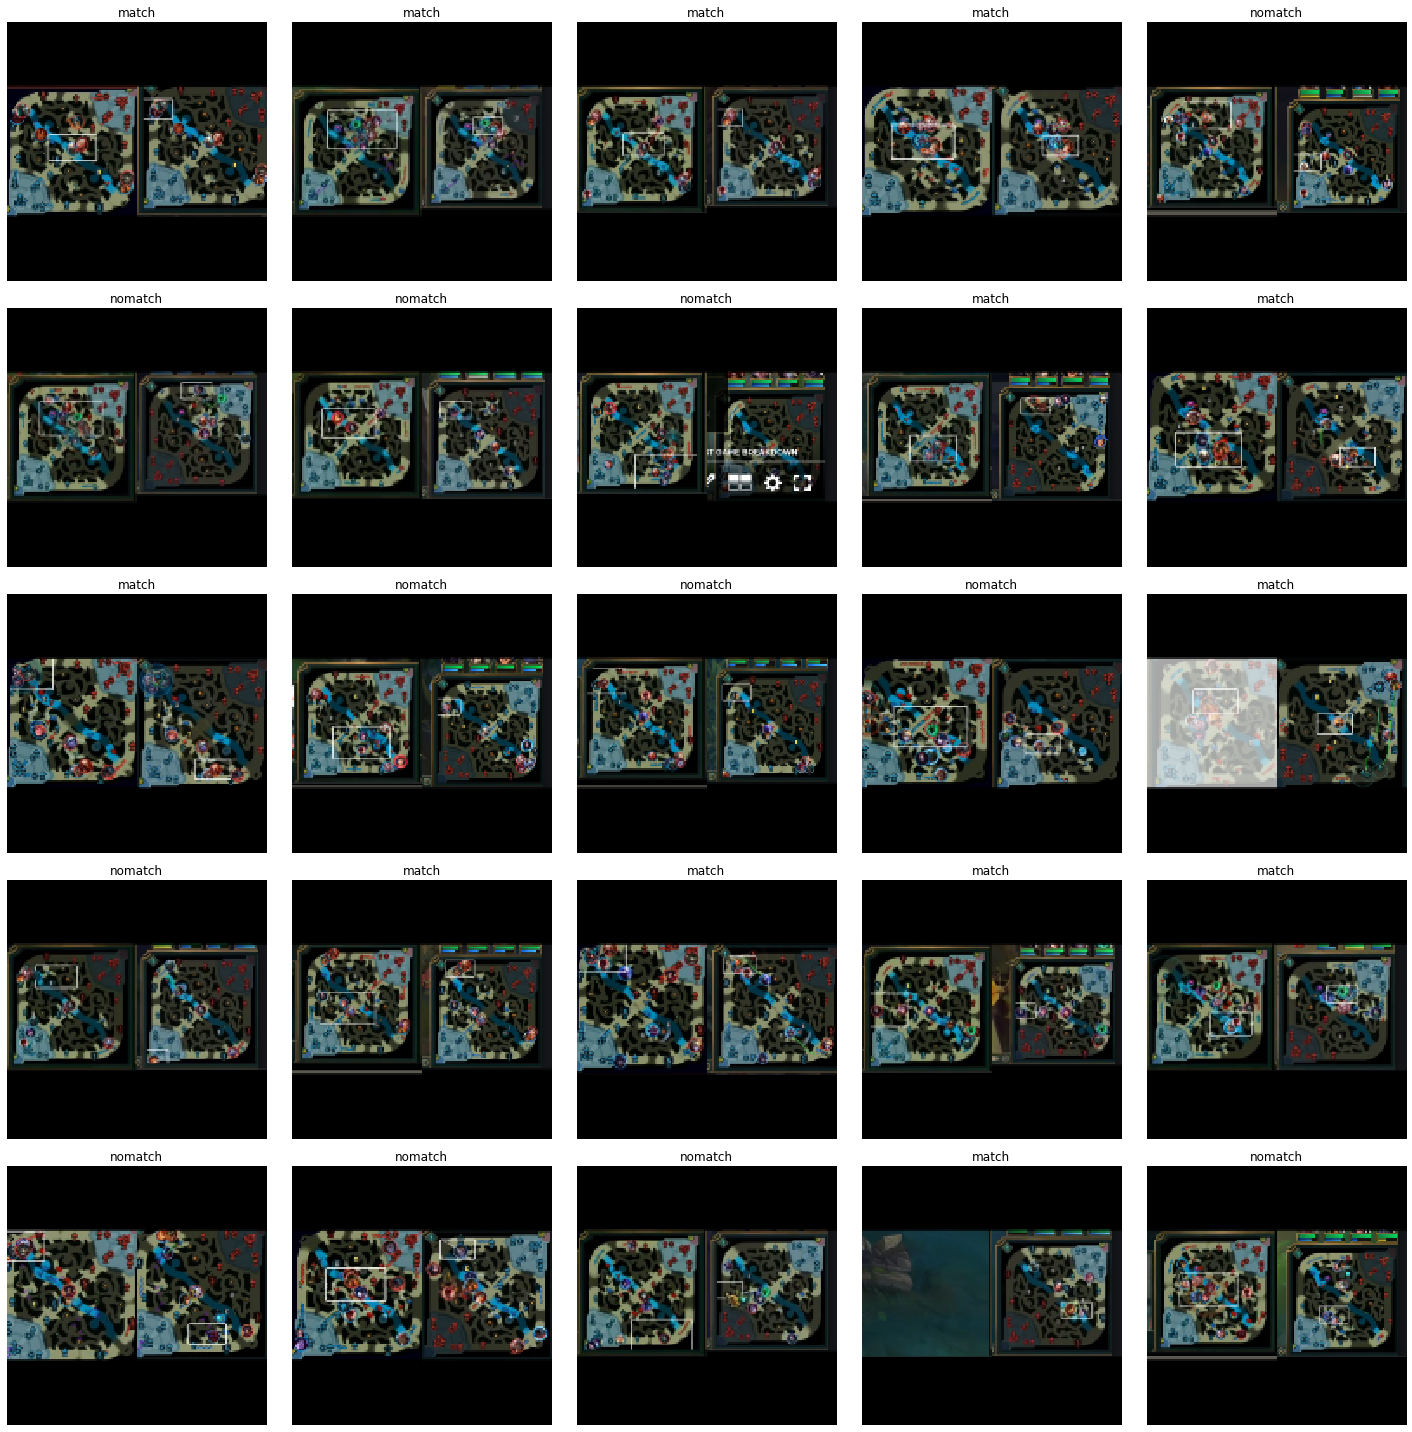

In [3]:
data = ImageDataBunch.from_folder("./games_matched", ds_tfms=[], size=150)
data.show_batch()

In [4]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)
learn.callbacks = [SaveModelCallback(learn, every='improvement', mode='min', name='best')]
learn.fit_one_cycle(1,1e-2)
learn.unfreeze()
learn.fit_one_cycle(10,1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.687828,0.688324,0.536830,06:03


Better model found at epoch 0 with valid_loss value: 0.6883235573768616.


epoch,train_loss,valid_loss,accuracy,time
0,0.332787,0.340645,0.844837,08:02
1,0.271122,0.269550,0.874967,08:01
2,0.174989,0.258703,0.879205,08:00
3,0.147608,0.225080,0.915164,07:59
4,0.133619,0.142327,0.933856,08:00
5,0.121081,0.122574,0.940919,08:00
6,0.092931,0.103049,0.951109,08:00
7,0.083338,0.077915,0.962807,08:00
8,0.051216,0.062145,0.971708,08:00
9,0.041873,0.061964,0.972942,08:01


Better model found at epoch 0 with valid_loss value: 0.34064528346061707.
Better model found at epoch 1 with valid_loss value: 0.26955023407936096.
Better model found at epoch 2 with valid_loss value: 0.2587028443813324.
Better model found at epoch 3 with valid_loss value: 0.2250799685716629.
Better model found at epoch 4 with valid_loss value: 0.14232733845710754.
Better model found at epoch 5 with valid_loss value: 0.122574083507061.
Better model found at epoch 6 with valid_loss value: 0.1030486449599266.
Better model found at epoch 7 with valid_loss value: 0.07791513204574585.
Better model found at epoch 8 with valid_loss value: 0.06214459612965584.
Better model found at epoch 9 with valid_loss value: 0.06196393445134163.


# Identify Mismatched 

In [5]:
janked = []

test = ImageList.from_folder("./games_matched/train/match")
learn.data.add_test(test)
preds = learn.get_preds(ds_type=DatasetType.Test)
janked = []
for i in range(len(preds[0])):
    if preds[0][i][0] < 0.5:
        janked.append(learn.data.test_dl.items[i])
        
test = ImageList.from_folder("./games_matched/valid/match")
learn.data.add_test(test)
preds = learn.get_preds(ds_type=DatasetType.Test)
for i in range(len(preds[0])):
    if preds[0][i][0] < 0.5:
        janked.append(learn.data.test_dl.items[i])
        
len(janked)

2620

In [6]:
j = 0

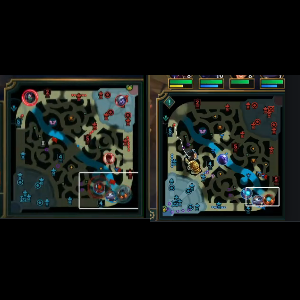

In [9]:
img = PIL.Image.open(janked[j])
j += 1
img

In [10]:
janked = [os.path.basename(j) for j in janked]

In [17]:
janked.sort()
janked[:5]

['ahq_dwg_1_worlds_oct_13_2019_0000000498.png',
 'ahq_dwg_1_worlds_oct_13_2019_0000000626.png',
 'ahq_dwg_1_worlds_oct_13_2019_0000000627.png',
 'ahq_dwg_1_worlds_oct_13_2019_0000000628.png',
 'ahq_dwg_1_worlds_oct_13_2019_0000000714.png']

In [20]:
missed = 0
for j in janked:
    try:
        os.remove("./games_enhanced/"+j)
    except:
        missed+=1

print(f"{missed}/{len(janked)}")

5240/5240
